### Dpi Setting

In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


# Dependencies

### Python

In [4]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [5]:
!apt-get install -y r-base
!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [6]:
from rpy2.robjects.packages import importr


In [7]:
%load_ext rpy2.ipython

### R

In [8]:
%%R

if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

Loading required package: WaveSampling
Loading required package: Matrix
Loading required package: sampling
Loading required package: BalancedSampling
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


### Imports

In [9]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numpy2ri.activate()

rng = gs.random.rng()

/home/divar/projects/geometric-sampling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

### Scores in R

In [10]:
def scores(coords, probs, n, N, sample_idx):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    ro.globalenv['sample_mask'] = sample_mask
    ro.globalenv['sample_idx'] = sample_idx + 1
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs
    ro.globalenv['n'] = n
    ro.globalenv['N'] = N

    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]

    scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
    density_measure = gs.measure.Density(scaled_coords, probs, n)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[1][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value

# Handpicked Cases

## Linear 1D

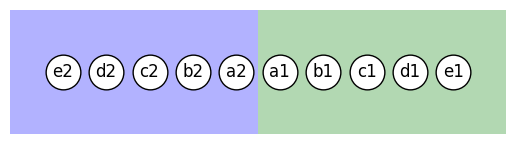

   Sample   # Density Voronai  Moran Local Balance
0   ai aj   1    0.14     0.0  -0.25          0.49
1   ai bi   2    0.14    0.04  -0.06          0.55
2   ai bj   2    0.11    0.04  -0.17          0.39
3   ai ci   2    0.11    0.04    0.0          0.52
4   ai cj   2    0.07    0.04  -0.79          0.36
5   ai di   2    0.07    0.16  -0.24          0.59
6   ai dj   2    0.02    0.16  -0.84          0.47
7   ai ei   2    0.02    0.25   -0.2          0.71
8   ai ej   2     0.0    0.16   -1.0          0.58
9   bi bj   1    0.07     0.0  -0.79          0.25
10  bi ci   2    0.14    0.16   0.06          0.69
11  bi cj   2    0.02    0.01  -0.84          0.18
12  bi di   2    0.11    0.36   0.13          0.76
13  bi dj   2     0.0    0.04   -1.0          0.28
14  bi ei   2    0.07    0.36  -0.13          0.85
15  bi ej   2    0.03    0.04  -0.76          0.42
16  ci cj   1     0.0     0.0   -1.0           0.0
17  ci di   2    0.14    0.36   0.19          0.89
18  ci dj   2    0.03    0.01  

In [11]:
points = {
    (0.35,): "a1",
    (-0.35,): "a2",
    (1.05,): "b1",
    (-1.05,): "b2",
    (1.75,): "c1",
    (-1.75,): "c2",
    (2.45,): "d1",
    (-2.45,): "d2",
    (3.15,): "e1",
    (-3.15,): "e2",
}

N = len(points)
n = 2
coords = np.array(list(points.keys()))
probs = rng.equal_probabilities(n, N)
fig, ax = plt.subplots()
for (x,), label in points.items():
    ax.plot(x, 0, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, 0, label, color="black", ha="center", va="center", fontsize=12)
ax.set_xlim(-4, 4)
ax.set_ylim(-1, 1)
ax.set_aspect("equal")
ax.axis("off")
ax.axvspan(0, 4, facecolor='green', alpha=0.3)
ax.axvspan(-4, 0, facecolor='blue', alpha=0.3)

plt.show()

dic_score = {}
for i, j in combinations(range(0, N), 2):
    i_label, j_label = points[tuple(coords[i])], points[tuple(coords[j])]
    if i_label[1] == j_label[1]:
        identifier = f"{i_label[0]}i {j_label[0]}i"
    else:
        identifier = f"{i_label[0]}i {j_label[0]}j"
    sample_idx = np.array([i, j])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 2)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.round(np.mean(all_scores, axis=0), 2)


result.append(
    np.concatenate([["Mean", len(all_scores)], overall_mean])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])
# print(df.to_latex(index=False))
print(df)

## 4 3x3

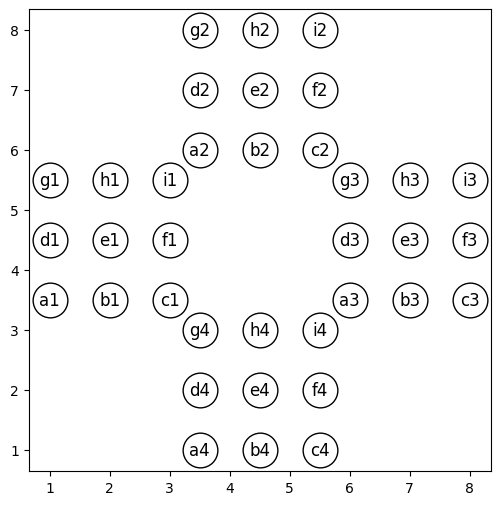

,Sample,Density,Voronai,Moran,Local Balance
0,e1 e2 e3 e4,0.00,0.00,-1.00,0.00
1,a1 a2 a3 a4,0.00,0.11,-0.59,0.43
2,d1 d2 d3 d4,0.00,0.02,-0.83,0.28
3,b1 d2 h3 f4,0.02,0.00,-0.75,0.19
4,f1 b2 d3 h4,0.33,0.00,-0.69,0.26
5,d1 h2 f3 b4,0.40,0.00,-0.50,0.26
6,a1 c1 g1 i1,0.34,0.56,0.38,0.84
7,b1 d1 f1 h1,0.48,0.56,0.52,0.79
8,h1 d2 b3 f4,0.03,0.00,-0.00,0.26


\begin{tabular}{llllll}
\toprule
 & Sample & Density & Voronai & Moran & Local Balance \\
\midrule
0 & e1 e2 e3 e4 & 0.00 & 0.00 & -1.00 & 0.00 \\
1 & a1 a2 a3 a4 & 0.00 & 0.11 & -0.59 & 0.43 \\
2 & d1 d2 d3 d4 & 0.00 & 0.02 & -0.83 & 0.28 \\
3 & b1 d2 h3 f4 & 0.02 & 0.00 & -0.75 & 0.19 \\
4 & f1 b2 d3 h4 & 0.33 & 0.00 & -0.69 & 0.26 \\
5 & d1 h2 f3 b4 & 0.40 & 0.00 & -0.50 & 0.26 \\
6 & a1 c1 g1 i1 & 0.34 & 0.56 & 0.38 & 0.84 \\
7 & b1 d1 f1 h1 & 0.48 & 0.56 & 0.52 & 0.79 \\
8 & h1 d2 b3 f4 & 0.03 & 0.00 & -0.00 & 0.26 \\
\bottomrule
\end{tabular}



In [12]:
samples = np.array([
    ["e1", "e2", "e3", "e4"],
    ["a1", "a2", "a3", "a4"],
    ["d1", "d2", "d3", "d4"],
    ["f4", "h3", "d2", "b1"],
    ["f1", "b2", "d3", "h4"],
    ["f3", "d1", "b4", "h2"],
    ["a1", "c1", "g1", "i1"],
    ["b1", "d1", "f1", "h1"],
    #### NEW Interstings
    "h1 d2 b3 f4".split(" "),
])

x3coords = rng.grid_coordinates((3, 2)) * 2
x3probs = rng.equal_probabilities(1, 9)

left = x3coords.copy()
right = x3coords.copy()
up = x3coords.copy()
down = x3coords.copy()

left_labels = [chr(ord('a') + i) + '1' for i in range(9)]
right_labels = [chr(ord('a') + i) + '3' for i in range(9)]
up_labels = [chr(ord('a') + i) + '2' for i in range(9)]
down_labels = [chr(ord('a') + i) + '4' for i in range(9)]

####### TEST
import itertools
# samples = np.array([
#     [l, u, r, d]
#     for l, u, r, d in itertools.product(left_labels, up_labels, right_labels, down_labels)
# ])
#######

left[:, 0] += 1
left[:, 1] += 3.5
right[:, 0] += 6
right[:, 1] += 3.5
up[:, 0] += 3.5
up[:, 1] += 6
down[:, 0] += 3.5
down[:, 1] += 1


coords = np.vstack([left, right, up, down])
probs = np.concatenate([x3probs, x3probs, x3probs, x3probs])
labels = np.concatenate([left_labels, right_labels, up_labels, down_labels])
label_to_idx = {l: idx for idx, (c, l) in enumerate(zip(coords, labels))}
assert len(probs) == len(coords) == len(labels)

N = len(coords)
n = 4
points = {}
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")
for (x, y), label in zip(coords, labels):
    points[label] = (x, y)
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', label=1, markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

plt.show()

results = []
for sample in samples:
    sample_idx = np.array([label_to_idx[s] for s in sample])
    identifier = " ".join(sorted(sample, key=lambda x: x[1]))
    s = scores(coords, probs, n, N, sample_idx)
    s_formatted = [f"{num:.2f}" for num in s]  # Corrected line
    results.append([identifier] + s_formatted)

df = pd.DataFrame(results, columns=["Sample", "Density", "Voronai", "Moran", "Local Balance"])
display(df)
print(df.to_latex())


## Rotating

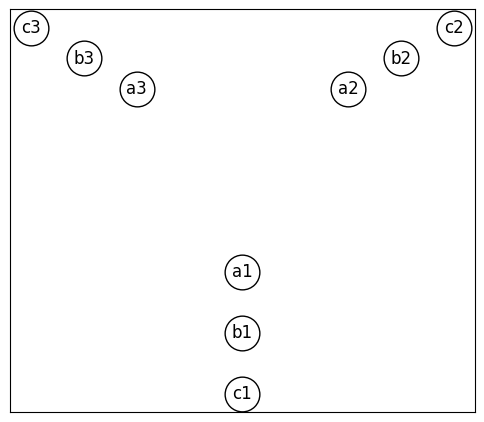

,Sample,#,Density,Voronai,Moran,Local Balance
0,aaa,1,0.56,0.0,-1.0,0.263
1,aab,3,0.3,0.0,-1.0,0.214
2,aac,3,0.141,0.0,-1.0,0.263
3,abb,3,0.101,0.0,-1.0,0.152
4,abc,6,0.045,0.0,-1.0,0.214
5,acc,3,0.039,0.0,-1.0,0.263
6,bbb,1,0.0,0.0,-1.0,0.0
7,bbc,3,0.067,0.0,-1.0,0.152
8,bcc,3,0.161,0.0,-1.0,0.214
9,ccc,1,0.223,0.0,-1.0,0.263


In [13]:
def rotate_point(p, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.array([
        p[0] * cost - p[1] * sint,
        p[0] * sint + p[1] * cost
    ])

def rotate_matrix(matrix, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.apply_along_axis(rotate_point, 1, matrix, t, cost, sint)

template = np.array([
    [0.0, -0.5],
    [0.0, -1],
    [0.0, -1.5]
])
template = np.array([
    [0.0, -2],
    [0.0, -3],
    [0.0, -4]
])

angles = np.arange(0, 3) * (2.0 * np.pi / 3.0)
pop = np.vstack([rotate_matrix(template, angle) for angle in angles])

all_points = pop
labels = ["a1", "b1", "c1", "a2", "b2", "c2", "a3", "b3", "c3"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")

for (x, y), label in zip(all_points, labels):
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

ax.set_xticks([])
ax.set_yticks([])
plt.show()

N = len(all_points)
n = 3
coords = np.array(all_points)
probs = rng.equal_probabilities(n, N)

from itertools import combinations, combinations_with_replacement

dic_score = {}
for i, j, k in combinations(range(0, N), 3):
    i_label, j_label, k_label = labels[i], labels[j], labels[k]
    ids = list(sorted([i_label[0], j_label[0], k_label[0]]))
    identifier = "".join(ids)

    if len(set([i_label[1], j_label[1], k_label[1]])) != n:
      continue

    sample_idx = np.array([i, j, k])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 3)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.mean(all_scores, axis=0)


result.append(
    np.concatenate([["Mean", len(all_scores)], np.round(overall_mean, 2)])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])

display(df)
# print(df.to_latex())

# Simulations

## Methods

In [14]:
def local_pivotal_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
s <- lpm(probs, coords) # Local Pivotal Method
"""
        ro.r(r_code)
        sample_idx = np.array(list(ro.r("s"))) - 1
        samples_idx[i] = sample_idx

    return samples_idx

def k_means_samples(coords, probs, n, num_samples, n_zones):
    return gs.sampling.KMeansSpatialSampling(coords, probs, n=n, n_zones=n_zones, tolerance=5).sample(num_samples)

def random_samples(coords, probs, n, num_samples):
    return gs.sampling.RandomSampling(coords, probs, n=n).sample(num_samples)

def upmaxentropy_samples(probs, num_samples):
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
        mask <- UPmaxentropy(probs)
        """
        ro.r(r_code)
        mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

    return np.array(samples)


def wave_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx


def find_samples(coords, probs, n, num_samples):
    return {
        "K-Means (2, 2)": k_means_samples(coords, probs, n, num_samples, (1, 1)),
        "K-Means (5, 5)": k_means_samples(coords, probs, n, num_samples, (1, 1)),
        "Local Pivotal": local_pivotal_samples(coords, probs, n, num_samples),
        "Random": random_samples(coords, probs, n, num_samples),
        "UPmaxentropy": upmaxentropy_samples(probs, num_samples),
        # "Wave": wave_samples(coords, probs, n, num_samples),
    }

## Initial Population

In [15]:
n = 4 # Number of item in each sample (number of clusters)
sample_cnt = 5 # How many sample gather from each desiging method

### Coords

Uncomment each one you would like to get result from

In [16]:
swiss = 0
######### GRID
# grid_size = 20
# N = grid_size**2
# coords = rng.grid_coordinates((grid_size, 2))


######### RANDOM
N = 500
coords = rng.random_coordinates((N, 2))
idx = np.lexsort((coords[:,1], coords[:,0]))
coords = coords[idx]

######### CLUSTRED
n_clusters = 4
cluster_std = 0.05
# N = 400
coords = rng.cluster_coordinates(n_clusters, cluster_std, (N, 2))


######### SWISS: https://docs.google.com/spreadsheets/d/10uYLsZpxRV5lUrsGfy3gI0RD4fAn8lIP/edit?usp=sharing&ouid=117333816980669142577&rtpof=true&sd=true
swiss = 1
swiss_df = pd.read_csv('/home/divar/projects/geometric-sampling/swiss.csv')
coords = swiss_df[['COORD_X', 'COORD_Y']].to_numpy()
swiss_df['AREA'] = swiss_df['AREA'].clip(lower=1, upper=20)
N = len(coords)




idx = np.lexsort((coords[:,1], coords[:,0]))
coords = coords[idx]


### Probabilities

Uncomment each one you would like to get result from

In [17]:
######### EQUAL
probs = rng.equal_probabilities(n, N)


######### UNEQUAL
probs = np.sort(rng.unequal_probabilities(n, N))
probs = np.sort(rng.unequal_probabilities(n, N))[::-1]                                                          
# if swiss == 1:
#     probs = inclusion_probabilities(swiss_df['AREA'].to_numpy(), n)


## Results

### Plotting coords

In [18]:
# from scipy.spatial import ConvexHull
# from matplotlib.patches import Polygon

# def plot_convex_hull(
#         points, ax, color, alpha=0.3, edge_color="black", line_width=1.0
#     ):
#         if len(points) < 3:
#             return ax, None
#         hull = ConvexHull(points)
#         polygon = Polygon(
#             points[hull.vertices],
#             closed=True,
#             facecolor=color,
#             alpha=alpha,
#             edgecolor=edge_color,
#             lw=line_width,
#         )
#         ax.add_patch(polygon)
#         return ax, hull

# density_measure = gs.measure.Density(coords, probs, n)
# clusters, centroids = density_measure.clusters, density_measure.centroids
# fig, ax = plt.subplots()
# for cluster_idx, cluster in tqdm(enumerate(clusters), total=len(clusters), desc="Plotting clusters"):
#     cluster_points = cluster[:, 1:3]
#     cluster_color = plt.cm.tab10(cluster_idx % 10)
#     cmap = plt.get_cmap('tab10')         # get the colormap object
#     n_colors = cmap.N                  # how many entries it has
#     cluster_color = cmap(cluster_idx % n_colors)    # 
#     ax, _ = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.2)
#     ax.scatter(
#         cluster_points[:, 0],
#         cluster_points[:, 1],
#         color=cluster_color,
#         s=cluster[:, 3] * 1000,
#         alpha=0.8,
#     )
#     ax.grid(alpha=0.5)
#     # ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
#     # ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

# plt.tight_layout()
# plt.show()
# # ax.show()

Plotting clusters: 100%|██████████| 4/4 [00:00<00:00, 145.90it/s]


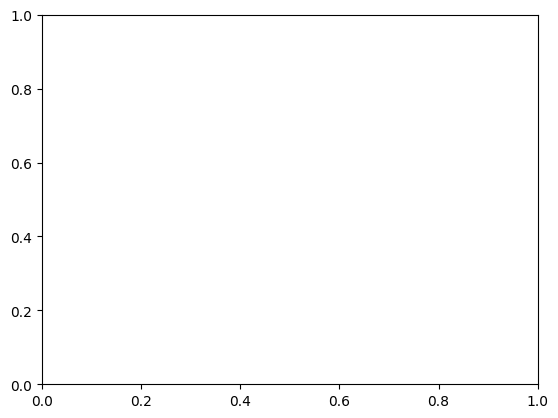

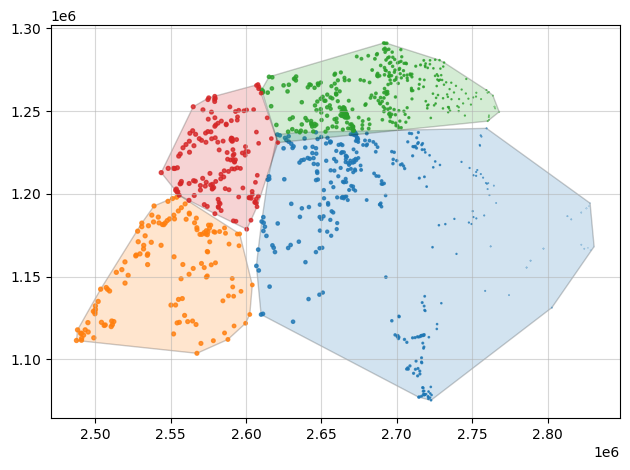

Sum of probs per cluster:
  Cluster 0: 1.0102
  Cluster 1: 1.0069
  Cluster 2: 1.0063
  Cluster 3: 1.0009


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
from tqdm import tqdm

# ---- define your plot_convex_hull as before ----
def plot_convex_hull(
        points, ax, color, alpha=0.3, edge_color="black", line_width=1.0
    ):
        if len(points) < 3:
            return ax, None
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
        )
        ax.add_patch(polygon)
        return ax, hull

density_measure = gs.measure.Density(coords, probs, n)
clusters, centroids = density_measure.clusters, density_measure.centroids
fig, ax = plt.subplots()
cluster_sizes = []
probs_sums = []

fig, ax = plt.subplots()

for cluster_idx, cluster in tqdm(enumerate(clusters), total=len(clusters), desc="Plotting clusters"):
    cluster_points = cluster[:, 1:3]
    cluster_indices = cluster[:, 0].astype(int)  # assuming first column in cluster is the index

    # Summing probs
    probs_sum = probs[cluster_indices].sum()
    probs_sums.append(probs_sum)

    # Plotting
    cmap = plt.get_cmap('tab10')         
    n_colors = cmap.N                  
    cluster_color = cmap(cluster_idx % n_colors)    
    
    ax, hull = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.2)
    
    ax.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        color=cluster_color,
        s=cluster[:, 3] * 1000,
        alpha=0.8,
    )
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()

print("Sum of probs per cluster:")
for idx, prob_sum in enumerate(probs_sums):
    print(f"  Cluster {idx}: {float(prob_sum):.4f}")

### Gathering Data

In [20]:
columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]

sample_methods = find_samples(coords, probs, n, sample_cnt)

rows = np.array([
    [method, *scores(coords, probs, n, N, s)]
    for method, samples in sample_methods.items()
    for s in tqdm(samples, total=sample_cnt)
])

df = pd.DataFrame(rows, columns=columns)
df = df.astype({
    "Density": float,
    "Voronoi": float,
    "Moran": float,
    "Local Balance": float
})

100%|██████████| 5/5 [01:10<00:00, 14.17s/it]


### Tables

Means

Describe

In [21]:
#df.groupby("Method").std()
#df.groupby("Method").mean()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df.groupby("Method").describe())

Density                                                    \
                 count      mean       std       min       25%       50%   
Method                                                                     
K-Means (2, 2)     5.0  0.098840  0.071507  0.038143  0.039250  0.068008   
K-Means (5, 5)     5.0  0.084326  0.039673  0.029443  0.070099  0.076648   
Local Pivotal      5.0  0.160894  0.121217  0.070435  0.105904  0.107783   
Random             5.0  0.276011  0.119465  0.131886  0.226690  0.233614   
UPmaxentropy       5.0  0.240094  0.053469  0.188451  0.202246  0.214255   

                                   Voronoi                                \
                     75%       max   count      mean       std       min   
Method                                                                     
K-Means (2, 2)  0.153802  0.194998     5.0  0.214578  0.182791  0.013976   
K-Means (5, 5)  0.116624  0.128814     5.0  0.195340  0.127236  0.017339   
Local Pivotal   0.148298  0.372052     5.0  0.163309  0.099367  0.071463   
Random          0.347698  0.440165     5.0  0.569601  0.488264  0.166559   
UPmaxentropy    0.294741  0.300778     5.0  0.333266  0.171166  0.164555   

                                                       Moran            \
                     25%       50%       75%       max count      mean   
Method                                                                   
K-Means (2, 2)  0.063347  0.220327  0.314758  0.460484   5.0 -0.084682   
K-Means (5, 5)  0.116127  0.244300  0.262624  0.336309   5.0 -0.099627   
Local Pivotal   0.074505  0.162429  0.196212  0.311937   5.0 -0.083097   
Random          0.322081  0.411291  0.539467  1.408605   5.0 -0.020790   
UPmaxentropy    0.243859  0.272114  0.378825  0.606979   5.0 -0.026764   

                                                                            \
                     std       min       25%       50%       75%       max   
Method                                                                       
K-Means (2, 2)  0.041201 -0.143039 -0.109276 -0.074425 -0.052350 -0.044321   
K-Means (5, 5)  0.035471 -0.130133 -0.129969 -0.101226 -0.093194 -0.043613   
Local Pivotal   0.041063 -0.140664 -0.095774 -0.084440 -0.066090 -0.028517   
Random          0.044941 -0.098756 -0.009798 -0.007590 -0.005282  0.017478   
UPmaxentropy    0.036895 -0.064182 -0.055777 -0.038091  0.007042  0.017191   

               Local Balance                                            \
                       count       mean        std       min       25%   
Method                                                                   
K-Means (2, 2)           5.0   0.655627   0.225800  0.361403  0.574683   
K-Means (5, 5)           5.0   3.874536   7.130486  0.392372  0.434685   
Local Pivotal            5.0   0.627820   0.305974  0.367570  0.377423   
Random                   5.0  14.904720  15.432220  0.310676  0.445382   
UPmaxentropy             5.0   0.738306   0.544165  0.415718  0.442084   

                                                 
                      50%        75%        max  
Method                                           
K-Means (2, 2)   0.628417   0.736136   0.977498  
K-Means (5, 5)   0.530788   1.406638  16.608196  
Local Pivotal    0.512458   0.808919   1.072731  
Random          16.787747  19.604647  37.375145  
UPmaxentropy     0.558632   0.571165   1.703931

### Plots

##### Color Pallet

In [22]:
methods = df["Method"].unique()
method_palette = dict(zip(methods, sns.color_palette("Pastel1", n_colors=len(methods))))

##### Boxplot

In [23]:
def remove_outliers(dataframe, column, IQR_coef, groupby_col=None):
    if groupby_col:
        def outlier_filter(group):
            Q1 = group[column].quantile(0.25)
            Q3 = group[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - IQR_coef * IQR
            upper = Q3 + IQR_coef * IQR
            return group[(group[column] >= lower) & (group[column] <= upper)]

        return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
    else:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - IQR_coef * IQR
        upper = Q3 + IQR_coef * IQR
        return dataframe[(df[column] >= lower) & (dataframe[column] <= upper)]

    return df

/tmp/ipykernel_16220/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
/tmp/ipykernel_16220/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
/tmp/ipykernel_16220/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply op

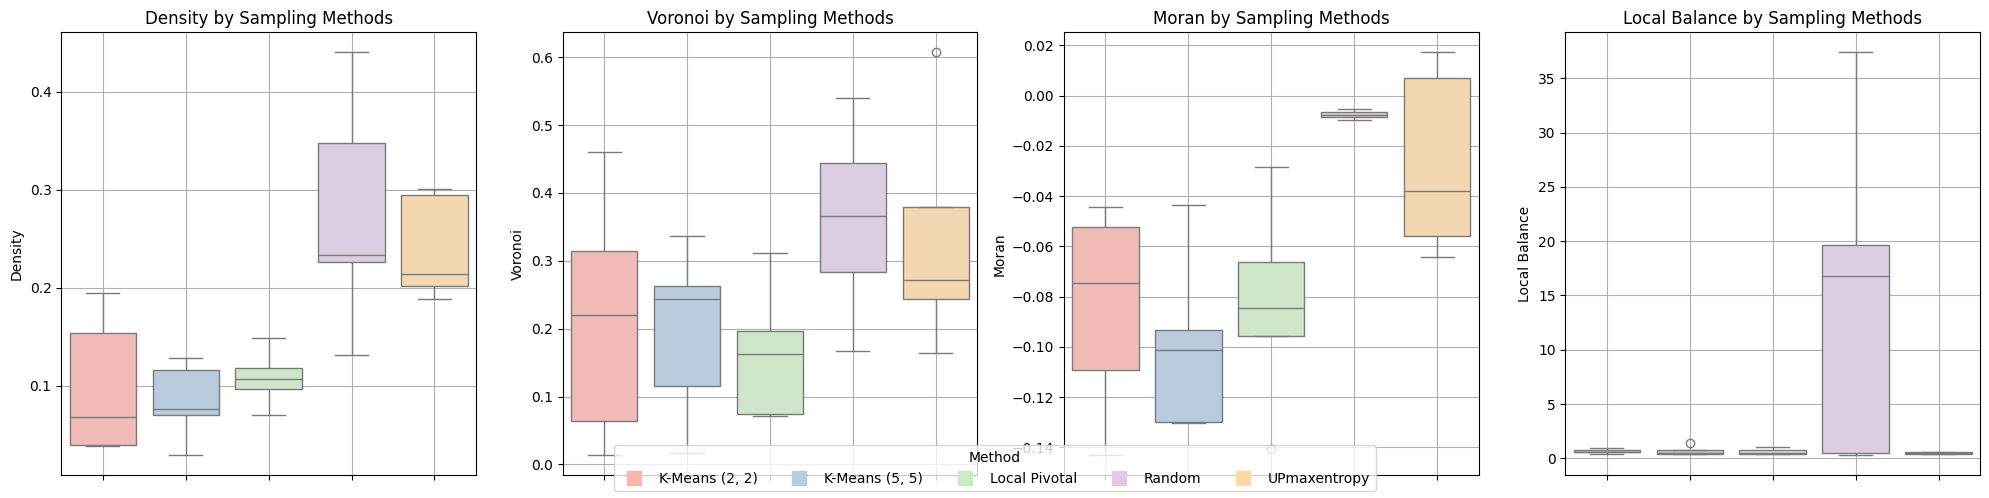

In [24]:
number_of_items = len(columns[1:])
n_cols = 4  # how many plots per row
n_rows = (number_of_items + n_cols - 1) // n_cols  # compute needed rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

axes = axes.flatten()

for idx, column in enumerate(columns[1:]):
    sns.boxplot(x="Method", y=column, data=remove_outliers(df, column, IQR_coef=3, groupby_col="Method"), hue="Method", palette=method_palette, ax=axes[idx])
    axes[idx].set_title(f'{column} by Sampling Methods')
    axes[idx].set_xlabel("")
    axes[idx].set_xticklabels([])
    axes[idx].grid(True)

handles = [plt.Line2D([0], [0], color=color, marker='s', linestyle='', markersize=10, label=method) for method, color in method_palette.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(methods), fontsize=10, title="Method")

fig.tight_layout()
plt.show()